# Latin Hypercube based Sampling with No Supervised Learning Region Seach

In [28]:
import numpy as np

In [29]:
def gradiente_numerico(f, x, h=1e-6): # ∇f
    x = np.asarray(x, dtype=float)
    grad = np.zeros_like(x)
    for i in range(len(x)):
        xp, xm = x.copy(), x.copy()
        xp[i] += h; xm[i] -= h
        grad[i] = (f(xp) - f(xm)) / (2*h)
    return grad

def hessiana_numerica(f, x, h=1e-4): # ∇²f
    x = np.asarray(x, dtype=float)
    n = len(x)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            x_pp = x.copy(); x_pm = x.copy()
            x_mp = x.copy(); x_mm = x.copy()
            x_pp[i] += h; x_pp[j] += h
            x_pm[i] += h; x_pm[j] -= h
            x_mp[i] -= h; x_mp[j] += h
            x_mm[i] -= h; x_mm[j] -= h
            Hij = (f(x_pp) - f(x_pm) - f(x_mp) + f(x_mm)) / (4*h*h)
            H[i, j] = Hij
            H[j, i] = Hij  # uso simetría
    return H

def newton_minimizar(f, x0, tol=1e-8, max_iter=50, damping=1e-6):
    x = np.asarray(x0, dtype=float)
    if x.ndim != 1:
        raise ValueError("x0 debe ser un array 1D")
    grad_norms = []
    
    for k in range(max_iter):
        g = gradiente_numerico(f, x)
        norm_g = np.linalg.norm(g)
        grad_norms.append(norm_g)
        if norm_g < tol:
            print(f"✅ Convergido en {k} iteraciones (||grad||={norm_g:.2e}).")
            return x, grad_norms
        
        H = hessiana_numerica(f, x)
        # Regularizar si está cerca de singular
        H += np.eye(len(x)) * damping
        
        # Comprobar simetría
        if not np.allclose(H, H.T, atol=1e-8):
            raise RuntimeError(f"Hessiana no simétrica en iteración {k}")
        
        try:
            delta = np.linalg.solve(H, -g)
        except np.linalg.LinAlgError:
            raise RuntimeError(f"Hessiana singular en iteración {k}")
        
        x = x + delta
    
    print(f"No convergió en {max_iter} iteraciones (||grad||={norm_g:.2e}).")
    return x, grad_norms

In [ ]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
from typing import List, Callable, Tuple
from scipy.spatial.distance import cdist

def plot_equation_3d(samples: np.array, fitnesses: np.array, s: int = 5, alpha: float = 0.6):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(samples[:, 0], samples[:, 1], fitnesses, c=fitnesses, cmap='viridis', s=s, alpha=alpha)

    ax.set_xlabel('x₀')
    ax.set_ylabel('x₁')
    ax.set_zlabel('f(x)')
    fig.colorbar(sc, ax=ax, label='f(x) latin hypercube')

    plt.title(f'Best sample fitness: {np.min(fitnesses)}')
    plt.tight_layout()
    plt.show()


def perform_latin_hypercube_sampling(n_samples: int, bounds: List[List[float]], dims: int, seed: int, my_function: Callable) -> Tuple[np.array, np.array]:
    lhs = qmc.LatinHypercube(d=dims, seed=seed)
    sample = lhs.random(n_samples)

    samples = qmc.scale(
        sample,
        l_bounds=bounds[0],
        u_bounds=bounds[1]
    )
    fitnesses = my_function(samples)
    return samples, fitnesses

def group_samples_by_density(samples: np.ndarray, fitnesses: np.ndarray) -> List[np.ndarray]:
    # 1) Ajustamos MeanShift y obtenemos etiquetas y centroides
    scaler = StandardScaler()
    model = MeanShift()
    model.fit(scaler.fit_transform(samples))
    labels = model.labels_
    centers = model.cluster_centers_

    # 2) Contamos cuántos elementos hay en cada cluster
    counts = np.bincount(labels)
    unique_labels = np.arange(len(counts))

    # 3) Identificamos labels de clusters con >= 2 elementos (válidos como destino)
    target_labels = unique_labels[counts >= 2]

    # 4) Identificamos labels de clusters singulares
    singleton_labels = unique_labels[counts == 1]

    # 5) Para cada singleton, buscamos el centro más cercano entre los target_labels
    for label in singleton_labels:
        idx = np.where(labels == label)[0][0]
        point = samples[idx]

        # Extraemos solo los centroides de los clusters destino
        target_centers = centers[target_labels]
        # Calculamos distancias del punto a esos centroides
        dists = cdist([point], target_centers).ravel()
        # Elegimos el label de destino con menor distancia
        nearest = target_labels[np.argmin(dists)]
        # Reasignamos la etiqueta
        labels[idx] = nearest

        # Actualizamos recuentos: ahora el target suma 1, y el singleton queda a 0
        counts[nearest] += 1
        counts[label] = 0

        # (Opcional) si tras esto hubiera clusters que pasen a ser singulares, ya no los
        # procesamos de nuevo, porque solo iteramos sobre singleton_labels iniciales.

    # 6) Reconstruimos y mostramos los clusters resultantes
    all_clusters_samples = []
    for label in np.unique(labels):
        mask = (labels == label)
        samples_in_cluster = samples[mask]
        fitnesses_in_cluster = fitnesses[mask]
        all_clusters_samples.append(samples_in_cluster)
        print(f"Cluster {label} ➞ {len(samples_in_cluster)} muestras, fitness medio = {fitnesses_in_cluster.mean():.3f}")

    print(f"\nNúmero final de clusters: {len(all_clusters_samples)}")
    return all_clusters_samples

def calculate_log_volume(bounds):
    lows, highs = np.array(bounds[0]), np.array(bounds[1])
    diffs = highs - lows
    return np.sum(np.log1p(diffs))

def calculate_new_bounds(cluster_samples: np.ndarray,
                         parent_bounds: List[List[float]]) -> List[List[float]]:
    """
    Calcula los bounds de un cluster, y los recorta (clamp) para que no
    excedan de los parent_bounds.
    """
    parent_lows  = np.array(parent_bounds[0])
    parent_highs = np.array(parent_bounds[1])
    samp_lows    = cluster_samples.min(axis=0)
    samp_highs   = cluster_samples.max(axis=0)

    # Clamp para garantizar containment
    child_lows  = np.maximum(parent_lows, samp_lows)
    child_highs = np.minimum(parent_highs, samp_highs)
    mask = child_lows > child_highs
    child_highs[mask] = child_lows[mask]
    child_lows[mask] = child_lows[mask] - 1e-2 #ESTO HAY QUE REVISAR
    child_highs[mask] = child_highs[mask] + 1e-2 #ESTO HAY QUE REVISAR


    child_bounds = [
        np.round(child_lows, 2).tolist(),
        np.round(child_highs, 2).tolist()
    ]

    # Sanity‑check: imprime si el volumen hubiera aumentado
    parent_vol = calculate_log_volume(parent_bounds)
    child_vol = calculate_log_volume(child_bounds)
    if child_vol > parent_vol:
        print("⚠️ Volumen hijo > volumen padre:",
              f"{child_vol:.2e} > {parent_vol:.2e}")
        print(" Parent bounds:", parent_bounds)
        print(" Child  bounds:", [child_lows.tolist(), child_highs.tolist()])

    return [child_lows.tolist(), child_highs.tolist()]

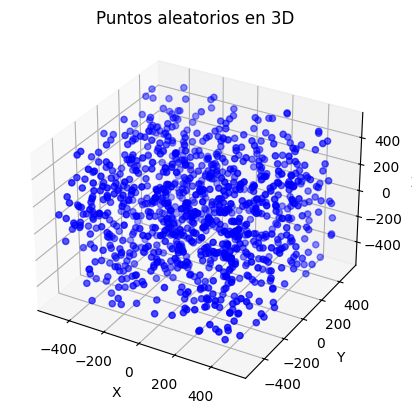

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Crear 100 puntos 2D y agregar una tercera dimensión
X = np.random.uniform(low=-512, high=512, size=(1_000, 2))
Z = np.random.uniform(low=-512, high=512, size=(1_000, 1))  # eje Z
X_3D = np.hstack((X, Z))  # (100, 3)

# Graficar
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2], c='blue', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Puntos aleatorios en 3D')
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sys
sys.path.append("..")
from src.equations import *


class TerminateAll(Exception):
    """Señal para terminar toda la recursión."""
    pass

# Parámetros globales
sampling_iterations = 10
n_samples = 1_000_000
seed = 42
dims = 30
percentile = 0.01 
K_stop = 2
my_function = ackley  # Asegúrate de definir esta función en tu entorno
tree_log = []  # 🧠 Aquí almacenamos el árbol
stop_value = 0.001 

def recursive_sampling(
        bounds,
        depth,
        best_so_far,
        vol_so_far,
        no_fitness_improve_count,
        no_vol_improve_count,
        stop_value):
    """
    Realiza muestreo recursivo con early stopping por rama.
    Al entrar, registra el nodo; si se detiene, no se generan hijos.
    """
    # 1) LHS + evaluación
    import time
    START = time.time()
    samples, fitnesses = perform_latin_hypercube_sampling(
        n_samples, bounds, dims, seed + depth, my_function
    )
    print(time.time() - START)
    raise Exception
    current_best = fitnesses.min()
    current_mean = fitnesses.mean()
    current_vol = calculate_log_volume(bounds)

    print(f"{'  '*depth}Depth {depth}: best = {current_best:.6f} | mean = {current_mean:.6f}")

    # 2) Guardar en tree_log al entrar
    tree_log.append({
        'depth': depth,
        'bounds': bounds,
        'volume': current_vol,
        'best_fitness': current_best
    })

    # 3) Actualizar conteo de mejora
    if current_best < best_so_far:
        best_so_far = current_best
        no_fitness_improve_count = 0
    else:
        no_fitness_improve_count += 1

    # 4) Conteo de reducción de volumen
    if current_vol < vol_so_far:
        vol_so_far = current_vol
        no_vol_improve_count = 0
    else:
        no_vol_improve_count += 1

    if stop_value and best_so_far <= stop_value:
        print(f"{'  '*depth}⏹ Stop: best <= {stop_value} | best = {best_so_far}.")
        raise TerminateAll()
    # 5) Paradas locales por rama
    if no_fitness_improve_count >= K_stop:
        print(f"{'  '*depth}⏹ Stop: sin mejora en {K_stop} iter.")
        return  # termina solo esta rama
    if no_vol_improve_count >= K_stop:
        print(f"{'  '*depth}⏹ Stop: sin reducción de volumen en {K_stop} iter.")
        return
    if depth + 1 >= sampling_iterations:
        print(f"{'  '*depth}⏹ Stop: máximo depth alcanzado.")
        return

    # 6) Top-1% + clustering
    cutoff = np.percentile(fitnesses, q=percentile)
    top_idx = np.where(fitnesses <= cutoff)[0]
    top_samples = samples[top_idx]
    top_fitnesses = fitnesses[top_idx]
    for i in range(top_samples.shape[0]):
        min_sample, _ = newton_minimizar(my_function, top_samples[i], max_iter=30)
        top_samples[i] = min_sample
        top_fitnesses[i] = my_function(min_sample)

    clusters = group_samples_by_density(top_samples, top_fitnesses)
    if not clusters:
        print(f"{'  '*depth}⏹ Stop: sin clusters.")
        return

    # 7) Recurse por cada clúster válido
    for i, cluster_samples in enumerate(clusters):
        if cluster_samples.shape[0] < 2:
            continue
        new_bounds = calculate_new_bounds(cluster_samples, bounds)
        print("LOWER BOUNDS")
        print(new_bounds[0])
        print("UPPER BOUNDS")
        print(new_bounds[1])

        print(f"{'  '*depth} -> rama {i}, {cluster_samples.shape[0]} pts")
        recursive_sampling(
            new_bounds,
            depth + 1,
            best_so_far,
            vol_so_far,
            no_fitness_improve_count,
            no_vol_improve_count,
            stop_value
        )


def print_tree_log(tree_log):
    print("\n🔍 Árbol de búsqueda:")
    for node in tree_log:
        indent = "  " * node['depth']
        bounds_str = np.round(node['bounds'], 2)
        fit = f"{node['best_fitness']:.4f}" if node['best_fitness'] is not None else "..."
        print(f"{indent}🔹 Depth {node['depth']} | "
              f"Vol: {node['volume']:.2e} | "
              f"Fitness: {fit} | "
              f"Bounds: {bounds_str.tolist()}")


def plot_tree_graph(tree_log, output_path='tree_graph.png'):
    from networkx.drawing.nx_agraph import to_agraph

    G = nx.DiGraph()
    for idx, node in enumerate(tree_log):
        node_id = str(idx)
        label = f"Depth: {node['depth']}"
        label += f"\nFitness: {node['best_fitness']:.2f}" if node['best_fitness'] is not None else "\nFitness: ..."
        label += f"\nLog Volume: {node['volume']:.3f}"
        G.add_node(node_id,
                   label=label,
                   shape="box",
                   style="rounded,filled",
                   fillcolor="#e6f2ff",
                   fontsize=10)

    # Conectar según profundidad
    parent_stack = []
    last_depth = -1
    for idx, node in enumerate(tree_log):
        curr_id = str(idx)
        curr_depth = node['depth']
        if curr_depth > last_depth:
            parent_stack.append(idx-1 if idx>0 else 0)
        elif curr_depth < last_depth:
            parent_stack = parent_stack[:curr_depth]
        if curr_depth > 0:
            G.add_edge(str(parent_stack[-1]), curr_id)
        last_depth = curr_depth

    A = to_agraph(G)
    A.graph_attr.update(rankdir="TB")  # Top to Bottom
    A.layout(prog="dot")
    A.draw(output_path)

    # Mostrar con matplotlib
    img = plt.imread(output_path)
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Árbol de Recursión de Optimización')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    bounds, _ = get_bounds_and_dimensions(my_function)
    bounds = [[bounds[0]] * dims, [bounds[1]] * dims]
    start_vol = calculate_log_volume(bounds)
    start_best = np.inf

    try:
        recursive_sampling(
            bounds,
            depth=0,
            best_so_far=start_best,
            vol_so_far=start_vol,
            no_fitness_improve_count=0,
            no_vol_improve_count=0,
            stop_value=stop_value
        )
    except TerminateAll:
        print("🏁 Terminación completa de todas las ramas.")



1.1375315189361572


Exception: 

In [72]:
print_tree_log(tree_log)


🔍 Árbol de búsqueda:


In [73]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph

def plot_tree_graph(tree_log, output_path='tree_graph.png'):
    G = nx.DiGraph()

    # 1) Crear nodos con etiqueta multiline
    for idx, node in enumerate(tree_log):
        nid = str(idx)
        label = f"Depth: {node['depth']}"
        label += f"\nBest Fitness: {node['best_fitness']:.3f}"
        label += f"\nSearch Space Log Volume: {node['volume']:.3f}"
        G.add_node(nid,
                   label=label,
                   shape="box",
                   style="rounded,filled",
                   fillcolor="#e6f2ff",
                   fontsize=10)

    # 2) Conectar padres e hijos según depth
    parent_stack = []
    last_depth = -1
    for idx, node in enumerate(tree_log):
        curr_id = str(idx)
        d = node['depth']
        if d > last_depth:
            parent_stack.append(idx - 1 if idx > 0 else 0)
        elif d < last_depth:
            parent_stack = parent_stack[:d]
        if d > 0:
            G.add_edge(str(parent_stack[-1]), curr_id)
        last_depth = d

    # 3) Convertir a AGraph y ajustar estilo global
    A = to_agraph(G)
    A.graph_attr.update(
        rankdir="TB",    # top→bottom
        ranksep="1.0",   # espacio vertical
        nodesep="0.6"    # espacio horizontal
    )

    # 4) Forzar cada nivel en su propia fila
    depths = sorted({n['depth'] for n in tree_log})
    for d in depths:
        nodes = [str(i) for i, n in enumerate(tree_log) if n['depth'] == d]
        if not nodes:
            continue
        sg = A.add_subgraph(nodes, name=f"cluster_depth_{d}")
        sg.graph_attr.update(rank="same")

    # 5) Layout y render
    A.layout(prog="dot")
    A.draw(output_path)

    # 6) Mostrar con matplotlib
    img = plt.imread(output_path)
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Árbol de Recursión de Optimización")
    plt.tight_layout()
    plt.show()

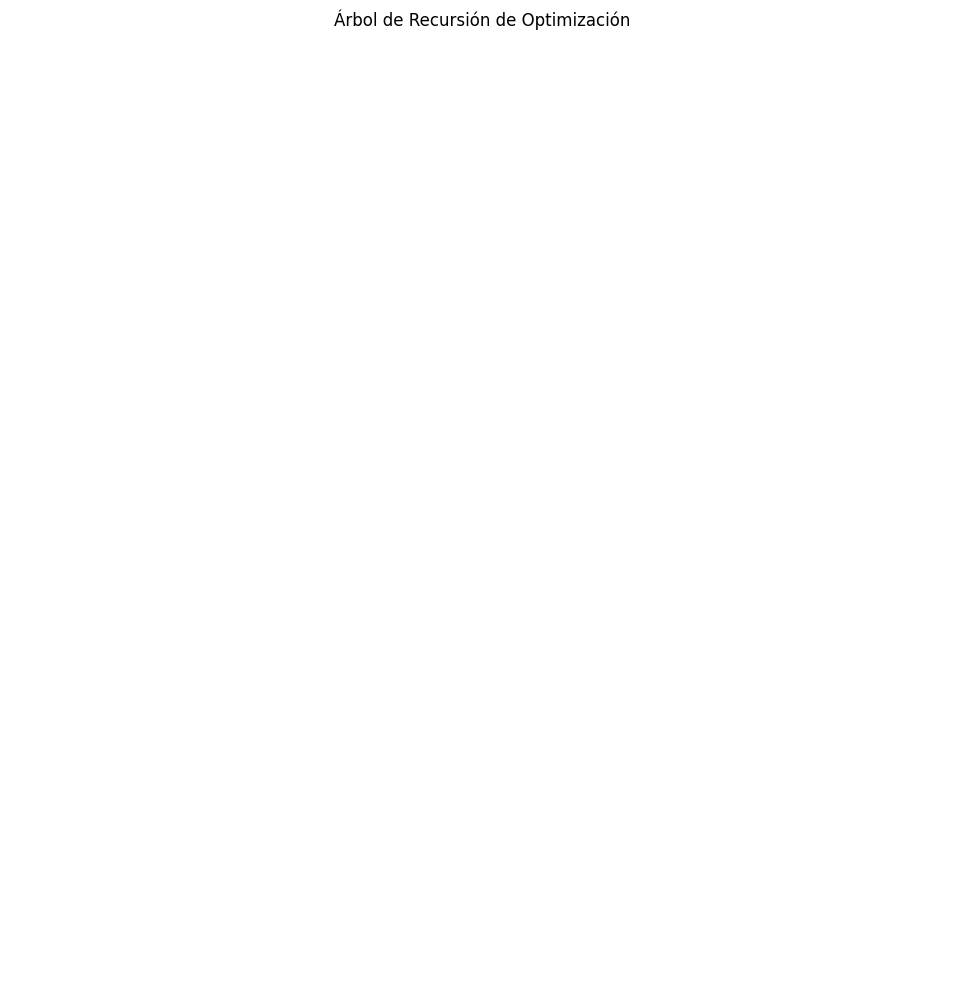

In [74]:
plot_tree_graph(tree_log)